In [1]:
import h2o
import utils
import transform
import evaluate
import configs.base_config as C
import explain 
import pandas as pd


# Start H2O
h2o.init(verbose=False)


Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


In [2]:
# Load the dataset
data = utils.read_from_files(C.DATA_DIR + 'simulated-data-raw/data/', "2018-08-24", "2018-09-30") # Fetch test month + 7 days from previous month


d:\Projects\AIPracticeProjects\ml-project\utils.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final = df_final.replace([-1], 0).infer_objects(copy=False)


In [3]:
# Transform
data = transform.extract_features(data)


In [4]:
# Only keep test data
data = data[data["TX_DATETIME"] >= (pd.to_datetime("2018-09-01").value // 1e9)].copy()


In [5]:
# Load model and get predictions on dataset
model_name = "isolation_forest"

if model_name == "isolation_forest":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=True
    )
    predictions = evaluate.get_isoforest_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "kmeans":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=True
    )
    predictions = evaluate.get_kmeans_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "lof":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=False
    )
    predictions = evaluate.get_lof_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "svm":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=False
    )
    predictions = evaluate.get_svm_predictions(
        model, data, model_parameters["feature_names"]
    )
elif model_name == "auto_encoder":
    model, background_data, model_parameters = utils.load_model(
        model_name, C.MODEL_DIR, is_h2o=True
    )
    predictions = evaluate.get_autoencoder_predictions(
        model, data, model_parameters["feature_names"]
    )

soft_anomaly, hard_anomaly = evaluate.classify_anomaly(
    predictions[model_parameters["output_name"]],
    model_parameters["soft_threshold"],
    model_parameters["hard_threshold"],
)


Loaded model isolation_forest
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [6]:
# Display anomaly points
data.reset_index(drop=True, inplace=True)
data["softAnomaly"] = soft_anomaly
data["hardAnomaly"] = hard_anomaly
data[(data["softAnomaly"] == 1) & (data["TX_FRAUD"] == 1)]


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,IS_WEEKEND,...,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,softAnomaly,hardAnomaly
138,1466420,1.535765e+09,1600,3944,76.29,13224685,153,1,2,1,...,13.0,60.670769,0.0,0.0,1.0,1.0,1.0,1.000000,True,True
140,1466422,1.535766e+09,4886,6954,6.34,13224768,153,1,2,1,...,23.0,7.248261,2.0,1.0,2.0,1.0,2.0,1.000000,True,True
177,1466459,1.535766e+09,1817,2170,615.65,13225555,153,1,3,1,...,16.0,198.275000,0.0,0.0,0.0,0.0,0.0,0.000000,True,True
309,1466591,1.535770e+09,3217,2438,250.97,13229374,153,1,1,1,...,22.0,127.709545,1.0,0.0,1.0,0.0,1.0,0.000000,True,True
689,1466971,1.535776e+09,1793,8545,690.75,13235498,153,1,3,1,...,33.0,116.893333,1.0,0.0,1.0,0.0,1.0,0.000000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286501,1752783,1.538330e+09,2341,1188,21.85,15788747,182,1,2,1,...,118.0,72.079746,1.0,1.0,10.0,0.3,41.0,0.073171,True,True
286745,1753027,1.538332e+09,4755,8935,41.28,15791025,182,1,2,1,...,65.0,71.450000,1.0,1.0,8.0,1.0,37.0,0.297297,True,True
286799,1753081,1.538332e+09,3059,8488,358.20,15791343,182,1,3,1,...,101.0,77.474653,0.0,0.0,9.0,0.0,43.0,0.000000,True,False
287391,1753673,1.538339e+09,4097,1558,24.04,15798652,182,1,2,1,...,63.0,41.877460,1.0,1.0,7.0,1.0,19.0,0.421053,True,True


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


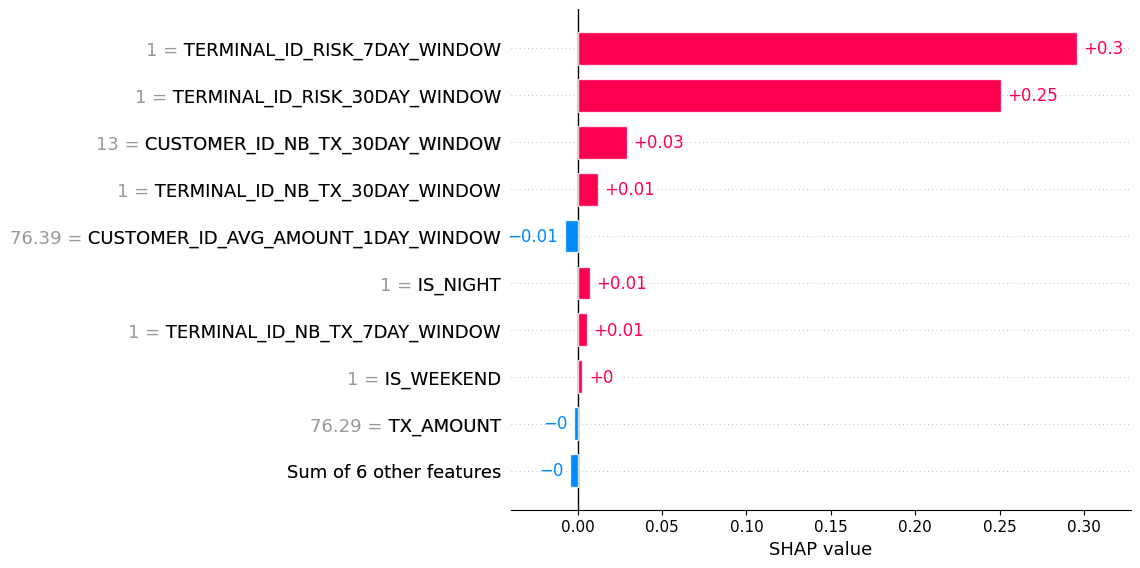

In [7]:
# Explain Anomaly using SHAP
# TODO check if SHAP correctly explains the reason for anomaly for fraud cases
h2o_wrapper = evaluate.H2OProbWrapper(model, model_parameters["feature_names"], model_parameters["output_name"])

predict_func = None
if model_name == "isolation_forest":
    predict_func = h2o_wrapper.predict_anomaly_score
elif model_name == "kmeans":
    predict_func = h2o_wrapper.predict_kmeans_distance
elif model_name == "lof":
    predict_func = h2o_wrapper.predict_lof_score
elif model_name == "svm":
    predict_func = h2o_wrapper.predict_svm_class
elif model_name == "auto_encoder":
    predict_func = h2o_wrapper.predict_reconstruction_error

shap_values = explain.explain_shap(
    data,
    138,
    predict_func,
    background_data,
    model_parameters,
)


In [8]:
# Commentary Generation
print(evaluate.generate_commentary(shap_values, model_parameters["feature_names"], 5))


Top 5 features affecting the anomaly score are:
1. TERMINAL_ID_RISK_7DAY_WINDOW increases the score by 0.30.
2. TERMINAL_ID_RISK_30DAY_WINDOW increases the score by 0.25.
3. CUSTOMER_ID_NB_TX_30DAY_WINDOW increases the score by 0.03.
4. TERMINAL_ID_NB_TX_30DAY_WINDOW increases the score by 0.01.
5. CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW decreases the score by 0.01.



In [9]:
# Shutdown H2O
h2o.cluster().shutdown()
